## What is the goal of this project?

#### The school world contains so much data and yet barely any schools are taking advantage of it.
#### Their administrators don't have the time to dig deep into the data and pull out information
#### This project will act almost as a POC to a potential plugin/dashboard that schools can enter into their Student Information Systems where administrators can quickly yield results that will help guide them to action

#### Some questions that we will be exploring: Can we predict the ELA (English Language Acquisition) status/level of a student based on their grade? What about their current english grade based on the last 3 years of English test grades? Taking a mixed effect model and looking at differences. 
#### There are many more questions we can ask of the data, but for our current scope, we will focus on these 3.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import metrics
%matplotlib inline

In [103]:
# Loading the data in long format (each respondent has one row per response)
data=pd.read_csv('Report.csv')
#elaDummies = pd.get_dummies(data["ca_elastatus"])
#data = data.append(elaDummies)
print(data.shape)
print(data.columns)

(940, 18)
Index(['student_number', 'grade_level', 'ca_elastatus', 'Race', 'Zip', 'E1',
       'E2', 'E3', 'M1', 'M2', 'M3', 'Days Attended', 'Days Absent 2018-2019',
       'Days Enrolled 2018-2019', 'Attendance Rate 2018-2019',
       'Absent Rate 2018-2019', 'Current English Grade', 'Current Math Grade'],
      dtype='object')


### Data cleanup and converting non-numerical fields to numeric

In [104]:
#I'm not exactly happy with this as we're essentially giving students 0 for missing data, but we have to start somewhere
#I might run another dataset dropping them and looking at the difference.
data= data.dropna()

In [105]:
#This is going to take our grades that are in letters and convert them to numbers
#We're not going to worry too much about the + and - even though they have a slight difference, we will group them
def conditions(x):
    if (x == 'A' or x == 'A-'):
        return 1
    elif (x == 'B' or x == 'B+' or x == 'B-'):
        return 2
    elif (x == 'C' or x == 'C+' or x == 'C-'):
        return 3
    elif (x == 'D' or x == 'D-' or x == 'D+'):
        return 4
    elif (x == 'F'):
        return 5
    else:
        return 0

func = np.vectorize(conditions)
#do it for english grades
EngGradeDummies = func(data["Current English Grade"])
data["CurEngGrade"] = EngGradeDummies

#math
MathGradeDummies = func(data["Current Math Grade"])
data["CurMathGrade"] = MathGradeDummies

In [106]:
#this function will take our ELA status and convert them to numbers
def conditionsEla(x):
    if x == 'EO':
        return 1
    elif x == 'EL':
        return 2
    elif x == 'IFEP':
        return 3
    elif x == 'RFEP':
        return 4
    

func = np.vectorize(conditionsEla)
elaDummies = func(data["ca_elastatus"])
data["elastatus"] = elaDummies

In [ ]:
#OHE for race
race = pd.get_dummies(data["Race"])
data = data.append(race)
data = data.fillna(0)


In [76]:
data["absentrate"] = data["Days Absent 2018-2019"]
#create our X variable
mainSet = data[["student_number","grade_level", "absentrate", "E1", "E2", 'E3'
         , "M1", "M2", "M3", "Zip", "CurEngGrade", "CurMathGrade", "elastatus"]]

y = mainSet['elastatus']
X = mainSet.drop("elastatus", axis=1)

In [77]:
#clean up the spaces in some areas
X["E1"] = np.where(X["E1"] == ' ', 0, X["E1"]).astype("int")

X["E2"] = np.where(X["E2"] == ' ', 0, X["E2"]).astype("int")

X["E3"] = np.where(X["E3"] == ' ', 0, X["E3"]).astype("int")

X["M1"] = np.where(X["M1"] == ' ', 0, X["M1"]).astype("int")

X["M2"] = np.where(X["M2"] == ' ', 0, X["M2"]).astype("int")

X["M3"] = np.where(X["M3"] == ' ', 0, X["M3"]).astype("int")

c:\users\sakok\miniconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [78]:
#split the data for analysis
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Explore the data 

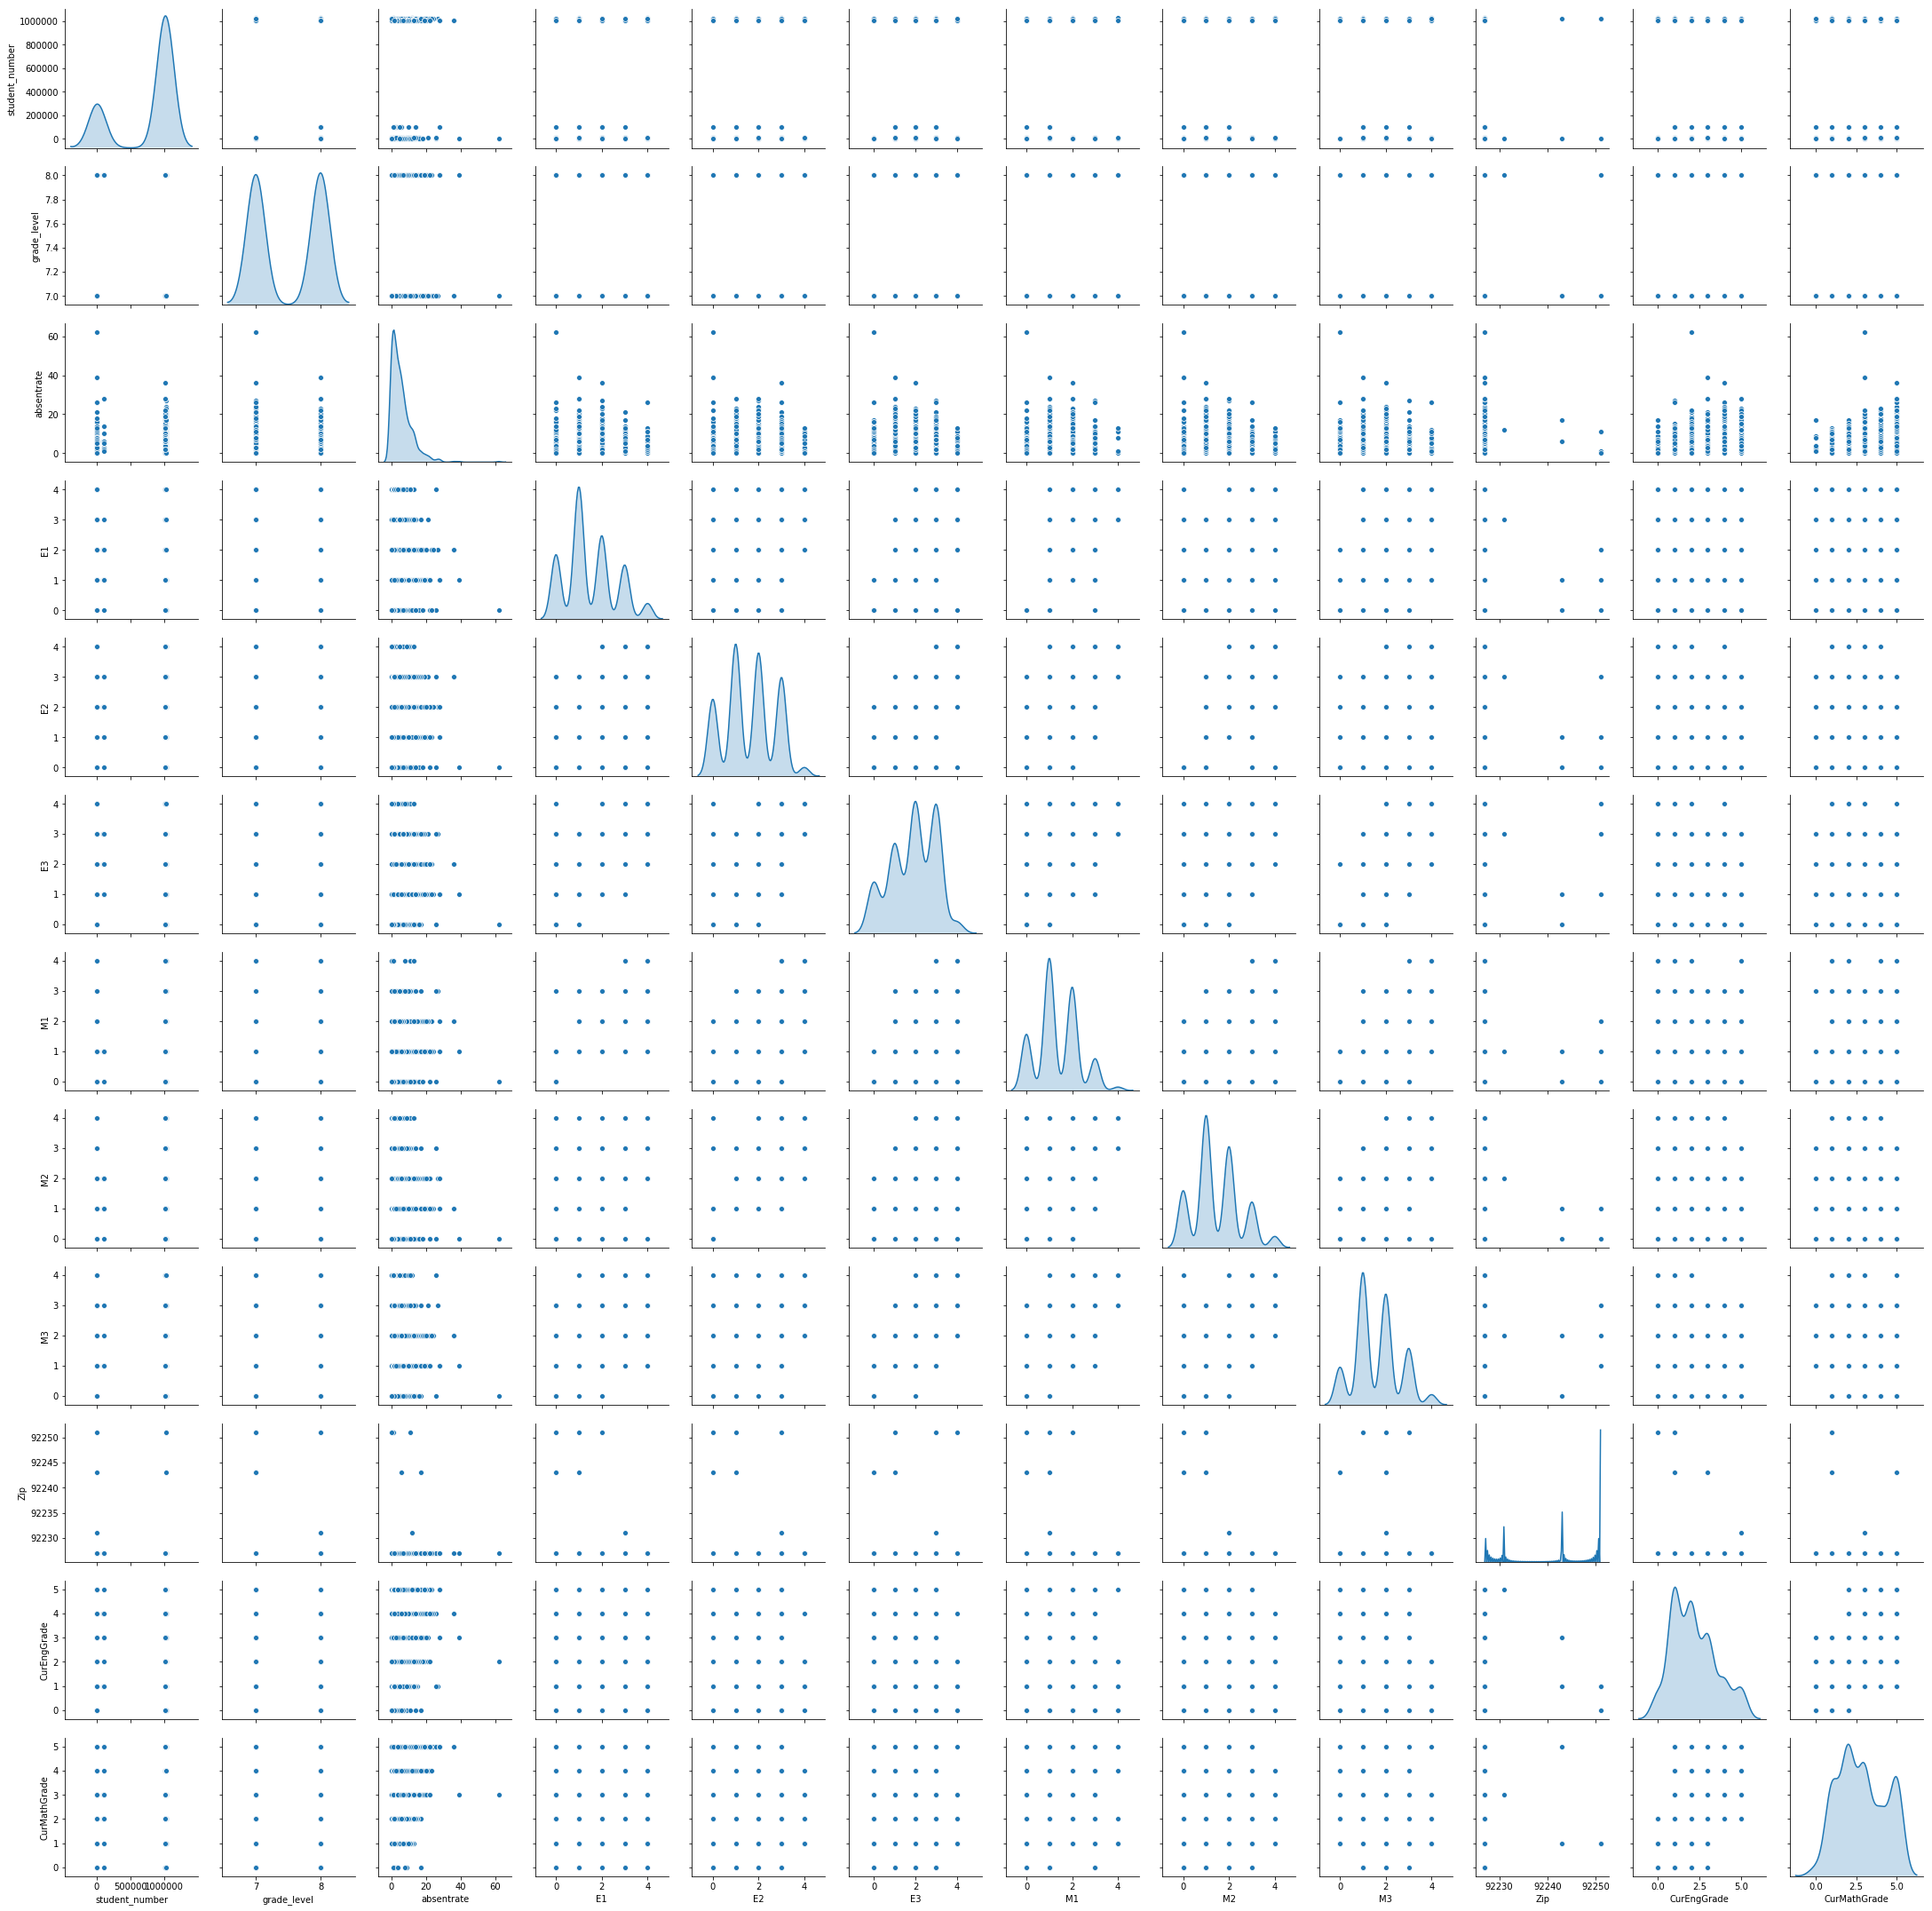

In [79]:
#explore the data a bit
sns.pairplot(X, diag_kind="kde")

### There is a lot of categorical data
#### Some of it is due to converting the grades and ELA status to OHE

In [80]:
summary = X.describe()
summary = summary.transpose()
summary

,count,mean,std,min,25%,50%,75%,max
student_number,646.0,761668.510836,436209.516059,69.0,102827.75,1004753.0,1020532.0,1024225.0
grade_level,646.0,7.503096,0.500378,7.0,7.00,8.0,8.0,8.0
absentrate,646.0,5.866873,6.145087,0.0,2.00,4.0,8.0,62.0
E1,646.0,1.498452,1.095090,0.0,1.00,1.0,2.0,4.0
E2,646.0,1.614551,1.076186,0.0,1.00,2.0,2.0,4.0
E3,646.0,1.904025,1.062431,0.0,1.00,2.0,3.0,4.0
M1,646.0,1.371517,0.915699,0.0,1.00,1.0,2.0,4.0
M2,646.0,1.487616,1.018740,0.0,1.00,1.0,2.0,4.0
M3,646.0,1.623839,0.976938,0.0,1.00,2.0,2.0,4.0
Zip,646.0,92227.167183,1.862708,92227.0,92227.00,92227.0,92227.0,92251.0


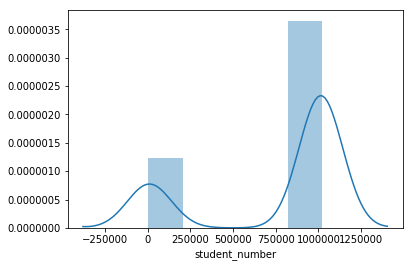

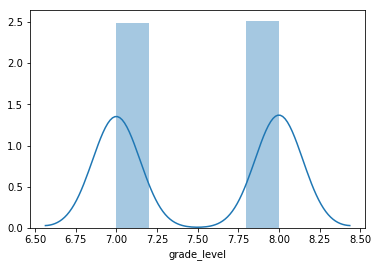

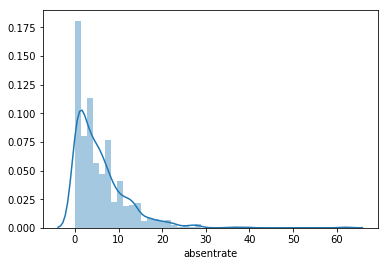

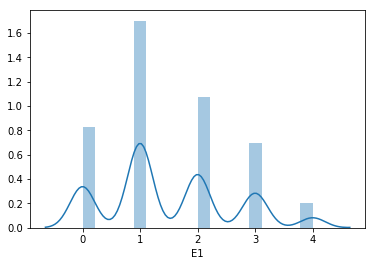

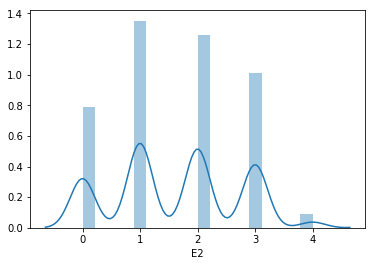

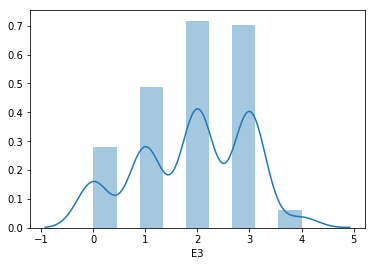

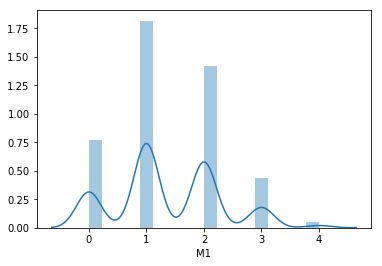

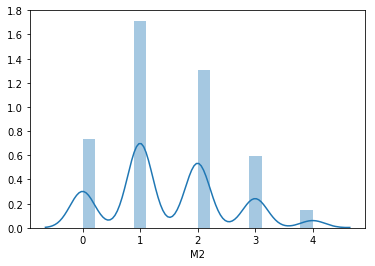

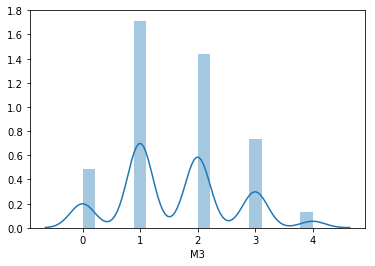

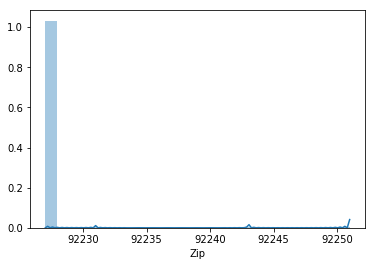

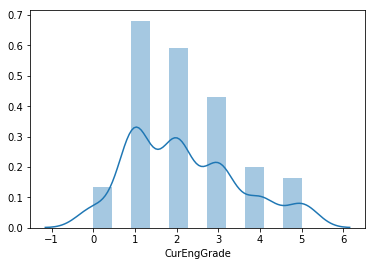

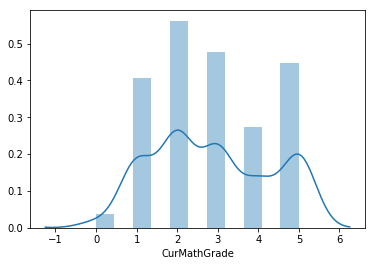

In [81]:
for x1 in X:
    sns.distplot(X[x1])
    plt.show()

In [82]:
#The interesting one for me is our distribution of ELA status at the bottom. 

## ELA Status of a student based on their English grades

In [83]:
#will start with a logistic regression as this is a classification problem

In [84]:
# Declare a logistic regression classifier.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Fit the model.
lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y = lr.predict(X_test)

print('\n Accuracy by ela status')
print(pd.crosstab(pred_y, y_test))

print('\n Percentage accuracy')
print(lr.score(X_train, y_train))

print("Cross Val Score")
print(cross_val_score(lr,X_test,y_test,cv=10))

Coefficients
[[ 4.98875657e-07 -5.16928034e-10 -3.63841556e-10  4.27160384e-10
   3.67761276e-10  1.87221541e-10  2.04380388e-10  1.35609285e-10
   1.29944262e-10 -6.43069827e-06 -1.32600420e-10  3.18188665e-11]
 [-1.00350294e-06 -3.29326425e-10 -3.31347838e-10 -7.20280118e-10
  -8.08813903e-10 -6.97073423e-10 -5.13809227e-10 -6.37702442e-10
  -5.23618627e-10 -2.50294100e-06  3.19818383e-10  1.27137231e-10]
 [-3.44759523e-07 -3.30679207e-09 -6.55863569e-09  5.58229675e-10
   9.28034891e-10  6.13973236e-10  3.27069746e-10  8.20218190e-10
   3.77259287e-10 -3.81735523e-05 -3.09022159e-09 -3.35223757e-09]
 [ 5.97726010e-07 -1.13667623e-09 -1.60773517e-09  8.22361954e-10
   1.08688200e-09  1.02574898e-09  7.23879869e-10  1.11530618e-09
   6.99706031e-10 -1.68990885e-05 -1.18180722e-09 -1.07010587e-09]]
[-6.61725347e-11 -2.96828704e-11 -4.62682167e-10 -1.91146376e-10]

 Accuracy by ela status
elastatus   1   2  3   4
row_0                   
1          85  28  3  54
2          14  20  2   8

c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model

In [85]:
y_train.value_counts()

1    190
2    124
4    112
3      6
Name: elastatus, dtype: int64

In [86]:
y_test.value_counts()

1    99
4    62
2    48
3     5
Name: elastatus, dtype: int64

In [87]:
print(metrics.classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           1       0.50      0.86      0.63        99
           2       0.45      0.42      0.43        48
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        62

   micro avg       0.49      0.49      0.49       214
   macro avg       0.24      0.32      0.27       214
weighted avg       0.33      0.49      0.39       214



c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [88]:
#next we will look at a random forest
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20)

rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)

print(rfc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(pred_rfc, y_test))

cross_val_score(rfc,X_test, y_test,cv=10)

1.0

 Accuracy by ela status
elastatus   1   2  3   4
row_0                   
1          65  15  4  35
2          17  32  0   7
4          17   1  1  20


c:\users\sakok\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.60869565, 0.56521739, 0.59090909, 0.5       , 0.59090909,
       0.47619048, 0.52380952, 0.57142857, 0.5       , 0.63157895])

In [89]:
print(metrics.classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           1       0.55      0.66      0.60        99
           2       0.57      0.67      0.62        48
           3       0.00      0.00      0.00         5
           4       0.51      0.32      0.40        62

   micro avg       0.55      0.55      0.55       214
   macro avg       0.41      0.41      0.40       214
weighted avg       0.53      0.55      0.53       214



c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
#Linear SVC
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)
#predictions
predsvc = svc.predict(X_test)

print(svc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(predsvc, y_test))

cross_val_score(svc,X_test, y_test,cv=10)


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed

0.20601851851851852

 Accuracy by ela status
elastatus   1   2  3   4
row_0                   
2          85  28  3  54
4          14  20  2   8


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

array([0.39130435, 0.04347826, 0.45454545, 0.22727273, 0.13636364,
       0.47619048, 0.23809524, 0.38095238, 0.25      , 0.47368421])